In [1]:
import torch as t
from scipy import ndimage
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [2]:
device = t.device('cuda' if t.cuda.is_available() else 'cpu')

In [3]:
class STESpike(t.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        return grad_output

In [4]:
MOORE_OFFSETS = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (0, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)
def get_moore_nbh(batch:t.Tensor):
    cell_pixel_coords = (batch == 1).nonzero()
    nbh_coords = (cell_pixel_coords[:, 1:].unsqueeze(1)+MOORE_OFFSETS.type(t.float).unsqueeze(0))
    idx_pad = cell_pixel_coords[:, 0].repeat(9,1).T.reshape(cell_pixel_coords[:, 0].shape[0], 9, 1)
    return t.concatenate((idx_pad, nbh_coords), dim=-1)

In [29]:
STEP_SIZES = t.tensor([(1, 1), (1, -1), (1, 0), (-1, 0), (-1, 1), (-1, -1), (0, 1), (0, -1)], device=device)

def MCS(batch, target_vol, temperature):
    batch_size, batch_height, batch_width = batch.shape
    frontiers = get_moore_nbh(batch)
    
    src_coords = []
    for batch_idx in range(batch_size):
        frontier = frontiers[frontiers[:, :, 0] == batch_idx, :].unique(dim=0)
        src_coords.append(random.choice(frontier).type(t.long))
    batch_src_coords = t.vstack(src_coords)
    step_sizes = t.vstack(random.choices(STEP_SIZES, k=batch_src_coords.shape[0]))
    #print(batch_src_coords)
    #print(step_sizes)
    tgt_coords = t.hstack((batch_src_coords[:, 0].unsqueeze(0).T, batch_src_coords[:, 1:] + step_sizes))
    #print(tgt_coords)
    tgt_coords[:, 1:][tgt_coords[:, 1:] == -1] = 1
    tgt_coords[:, 1:][tgt_coords[:, 1:] == batch_height] = batch_height -2
    tgt_i = tgt_coords[:, 0]
    tgt_j = tgt_coords[:, 1]
    tgt_k = tgt_coords[:, 2]
    src_i = batch_src_coords[:, 0]
    src_j = batch_src_coords[:, 1]
    src_k = batch_src_coords[:, 2]
    
    
    current_volumes = t.sum(batch, dim=(-1, -2))
    #print(current_volumes)
    
    vol_changes = (-1 * batch[tgt_i, tgt_j, tgt_k]) + batch[src_i, src_j, src_k]
    #print(vol_changes)
    adjusted_vols = current_volumes + vol_changes
    #print(adjusted_vols)
    
    unequal_mask = batch[tgt_i, tgt_j, tgt_k] != batch[src_i, src_j, src_k]
    sml_eq_two_mask = adjusted_vols <= 2
    greater_zero_mask = adjusted_vols > 0
    update_mask = t.logical_and(greater_zero_mask, t.logical_and(unequal_mask, sml_eq_two_mask))
    #print(update_mask)
    
    update_probabilities = t.exp(-((target_vol - adjusted_vols[update_mask]) ** 2) / temperature)
    #print(update_probabilities)
    residuals = t.rand_like(update_probabilities, device=device)
    upd_vals = STESpike.apply(update_probabilities - residuals) * vol_changes[update_mask]
    
    upd_i = tgt_i[update_mask]
    upd_j = tgt_j[update_mask]
    upd_k = tgt_k[update_mask]
    
    #print(upd_i, upd_j, upd_k)
    
    batch[upd_i, upd_j, upd_k] += upd_vals.squeeze()
    
    return batch
    

In [39]:
init_state = t.zeros(1,128,128, device=device)
init_state[:,64,64] += 1

state = init_state.detach().clone()
states = [init_state.detach().clone().cpu().numpy()]
for i in tqdm(range(20000)):
    state = MCS(state, 0, 27.)
    states.append(state.detach().cpu().numpy())

100%|██████████| 20000/20000 [00:53<00:00, 370.45it/s]


In [38]:
len(states)

10001

In [40]:
batch_idx = 0
imgs = [Image.fromarray((1-state[batch_idx])*255) for state in states]
imgs[0].save("ref_0.gif", save_all=True, append_images=imgs[1:], fps=60, loop=100)

In [14]:
init_state = t.zeros(2,128,128, device=device)
init_state[:,64,64] += 1
ref_state = init_state.detach().clone()

dist_matrix:np.ndarray = ndimage.distance_transform_edt(1-init_state[0].cpu(), return_indices=False)
dist_matrix = dist_matrix**2
dist_matrix_t = t.from_numpy(dist_matrix).to(device)
print(dist_matrix_t)

tensor([[8192.0000, 8065.0000, 7940.0000,  ..., 7817.0000, 7940.0000,
         8065.0000],
        [8065.0000, 7938.0000, 7813.0000,  ..., 7690.0000, 7813.0000,
         7938.0000],
        [7940.0000, 7813.0000, 7688.0000,  ..., 7565.0000, 7688.0000,
         7813.0000],
        ...,
        [7817.0000, 7690.0000, 7565.0000,  ..., 7442.0000, 7565.0000,
         7690.0000],
        [7940.0000, 7813.0000, 7688.0000,  ..., 7565.0000, 7688.0000,
         7813.0000],
        [8065.0000, 7938.0000, 7813.0000,  ..., 7690.0000, 7813.0000,
         7938.0000]], device='cuda:0', dtype=torch.float64)


In [22]:
def step(batch:t.Tensor, dist_matrix:t.Tensor, temperature:t.Tensor, target_vol:float, eta:float):
    temperature.requires_grad_()
    for i in tqdm(range(100)):
        #print(f"-------- MCS {i} --------------")
        batch = MCS(batch, target_vol, temperature)
        if t.any(t.sum(batch, dim=(-1,-2)) == 0) or t.any(t.sum(batch, dim=(-1,-2)) > 2):
            print("ISSUE DETECTED, STOP SIM")
            return None, None
    # calc the distance after 1000 steps    
    distances = t.sum(batch * dist_matrix, dim=(-1,-2)) / t.sum(batch, dim=(-1,-2))
    mean_distance = t.mean(distances)
    std_distance = t.std(distances)
    print(f"temperature: {temperature}, mean distance: {mean_distance}, standard dev.: {std_distance}")
    loss = (mean_distance - 3.5)**2 + (std_distance - 3.5)**2
    print(f"loss: {loss}")
    grad = t.autograd.grad(loss, temperature)[0]
    print(f"gradient: {grad}")
    return t.clamp(temperature - t.clamp(eta * grad, -0.1, 0.1), min=1e-5, max=40.), grad, loss

In [ ]:
temps = t.linspace(0, 35, 35)
target_vol = 0.

losses = []
grads = []
for temp in temps:
    temp.requires_grad_()
    batch = init_state.detach().clone()
    new_temp, grad, loss = step(batch, dist_matrix_t, temp, target_vol, eta=1)
    losses.append(loss.detach().cpu().numpy())
    grads.append(grad.detach().cpu().numpy())
    

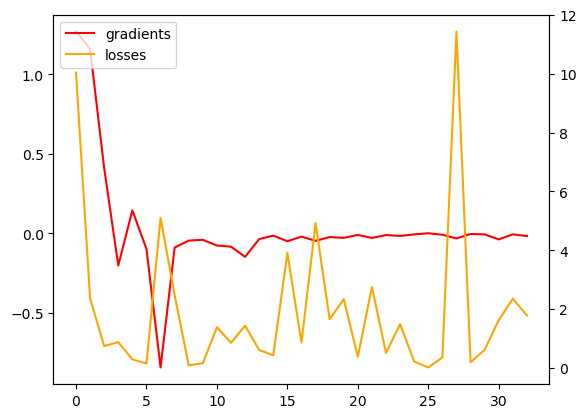

In [29]:
ax1 = plt.subplot()
l1, = ax1.plot(grads[2:], color='red')
ax2 = ax1.twinx()
l2, = ax2.plot(losses[2:], color='orange')

plt.legend([l1, l2], ["gradients", "losses"])

plt.show()

In [25]:
target_vol = 0.
temperature = t.distributions.Uniform(0, 40).sample().to(device)

grads = []
temps = []
losses = []
for i in range(50):
    batch = init_state.detach().clone()
    temperature, grad, loss = step(batch, dist_matrix_t, temperature, target_vol, eta=1)
    if temperature == None or grad == None:
        print("issue encountered in the simulations, stopping training")
        break
    else:
        grads.append(grad.detach().cpu().numpy())
        temps.append(temperature.detach().cpu().numpy())
        losses.append(loss.detach().cpu().numpy())

100%|██████████| 100/100 [00:19<00:00,  5.12it/s]


temperature: 20.318696975708008, mean distance: 4.715, standard dev.: 4.517225730239659
loss: 2.510973186261607
gradient: -0.015860743820667267


100%|██████████| 100/100 [00:15<00:00,  6.44it/s]


temperature: 20.334558486938477, mean distance: 4.12, standard dev.: 4.709285923671733
loss: 1.8467724451905971
gradient: -0.04785005748271942


100%|██████████| 100/100 [00:18<00:00,  5.46it/s]


temperature: 20.382408142089844, mean distance: 4.005, standard dev.: 3.7688884707207704
loss: 0.32732600968655445
gradient: -0.008425322361290455


100%|██████████| 100/100 [00:15<00:00,  6.45it/s]


temperature: 20.390832901000977, mean distance: 3.6, standard dev.: 4.192345160138331
loss: 0.48934182076697064
gradient: -0.020735111087560654


100%|██████████| 100/100 [00:15<00:00,  6.33it/s]


temperature: 20.41156768798828, mean distance: 3.845, standard dev.: 4.474221902040783
loss: 1.068133314415962
gradient: -0.02018047124147415


100%|██████████| 100/100 [00:18<00:00,  5.54it/s]


temperature: 20.431747436523438, mean distance: 3.785, standard dev.: 3.410659926978388
loss: 0.089206648647507
gradient: -0.0013891722774133086


 25%|██▌       | 25/100 [00:04<00:12,  6.10it/s]


KeyboardInterrupt: 

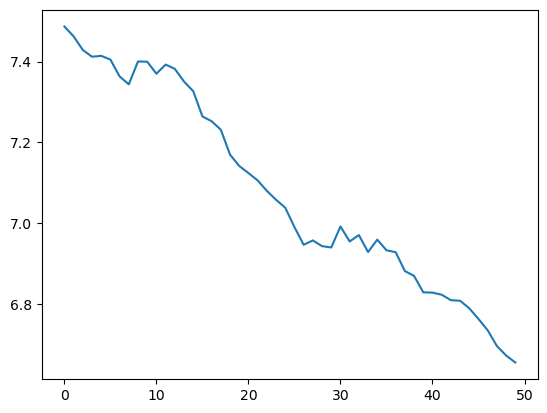

In [17]:
plt.plot(np.arange(50), temps)

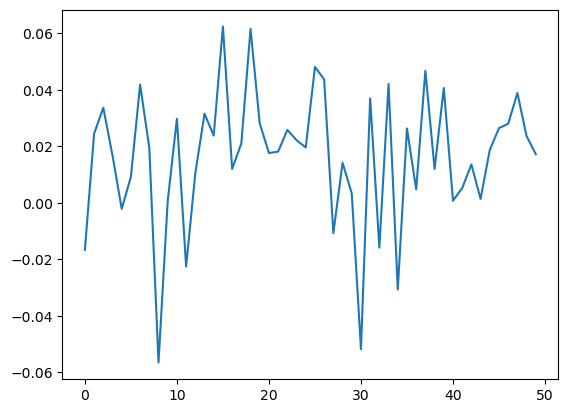

In [18]:
plt.plot(grads)

In [55]:
a = t.arange(32).reshape((2,4,4))
a[[0,1], [2,0], [3,1]]

tensor([11, 17])